# 📘 Fault Detection: Combined DE + FE Data
### CNN, CNN+LSTM, Residual CNN+BiLSTM Comparison

In [28]:
import scipy.io as sio
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, Flatten, Dense, Dropout, LSTM,
    BatchNormalization, Bidirectional, Input, LayerNormalization,
    Add, Layer, MultiHeadAttention, GlobalAveragePooling1D
)

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
import matplotlib.pyplot as plt

### Process data

In [39]:
import scipy.io as sio
import numpy as np
import os

def load_mat_data(file_path):
    """Load vibration data from .mat file (DE or FE)."""
    mat = sio.loadmat(file_path)
    key = [k for k in mat.keys() if 'DE' in k or 'FE' in k][0]
    return mat[key].squeeze()

# === Folder containing your 1797 RPM data ===
base_dir = r"D:\SAHANABHAT\python_projects\ml_bearing_fault\mat_data\1797\de"

# === File paths ===
files = [
    # Normal
    ("normal_0_1797.mat", 0),

    # Ball faults
    ("12k_de_B007_0.mat", 1),
    ("12k_fe_B007_0.mat", 1),

    # Inner race faults
    ("12k_de_IR007_0.mat", 2),
    ("12k_fe_IR007_0.mat", 2),

    # Outer race faults (all orientations)
    ("12k_de_OR007_3_0.mat", 3),
    ("12k_de_OR007_6_0.mat", 3),
    ("12k_de_OR007_12_0.mat", 3),
    ("12k_fe_OR007_3_0.mat", 3),
    ("12k_fe_OR007_6_0.mat", 3),
    ("12k_fe_OR007_12_0.mat", 3),
]

# === Load all data ===
X, y = [], []
for file_name, label in files:
    file_path = os.path.join(base_dir, file_name)
    data = load_mat_data(file_path)
    segments = len(data) // 1024  # Segment signal into windows
    data = data[:segments * 1024].reshape(segments, 1024)
    X.append(data)
    y.extend([label] * segments)

# === Combine ===
X = np.vstack(X)
y = np.array(y)

print("Combined Shape:", X.shape, y.shape)
print("Label Distribution:", np.bincount(y))


Combined Shape: (1422, 1024) (1422,)
Label Distribution: [238 237 236 711]


### Standardize & split data

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))
print("Class Weights:", class_weights)

Class Weights: {0: np.float64(1.4960526315789473), 1: np.float64(1.503968253968254), 2: np.float64(1.503968253968254), 3: np.float64(0.4995606326889279)}


### Model definitions

In [44]:
def build_simple_cnn(input_shape, num_classes):
    model = Sequential([
        Conv1D(32, 5, activation='relu', input_shape=input_shape),
        MaxPooling1D(2),
        Conv1D(64, 5, activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


def build_cnn_lstm(input_shape, num_classes):
    model = Sequential([
        Conv1D(32, 5, activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling1D(2),

        Conv1D(64, 5, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),

        LSTM(64, return_sequences=False),
        Dropout(0.5),

        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    optimizer = Adam(learning_rate=1e-4, clipnorm=1.0)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


def build_residual_cnn_bilstm(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    x = Conv1D(64, 7, padding='same', activation='relu')(inputs)
    x = LayerNormalization()(x)
    x = MaxPooling1D(2)(x)
    x = Dropout(0.2)(x)

    shortcut = Conv1D(128, 1, padding='same')(x)
    x = Conv1D(128, 5, padding='same', activation='relu')(x)
    x = LayerNormalization()(x)
    x = Conv1D(128, 5, padding='same', activation='relu')(x)
    x = Add()([x, shortcut])
    x = MaxPooling1D(2)(x)
    x = Dropout(0.3)(x)

    shortcut = Conv1D(256, 1, padding='same')(x)
    x = Conv1D(256, 3, padding='same', activation='relu')(x)
    x = LayerNormalization()(x)
    x = Conv1D(256, 3, padding='same', activation='relu')(x)
    x = Add()([x, shortcut])
    x = MaxPooling1D(2)(x)
    x = Dropout(0.4)(x)

    x = Bidirectional(LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))(x)
    x = Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3))(x)
    x = LayerNormalization()(x)

    x = Dense(128, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    lr_schedule = CosineDecayRestarts(initial_learning_rate=1e-3, first_decay_steps=500)
    optimizer = Adam(learning_rate=lr_schedule)

    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model


Transformer-CNN

In [43]:
class TransformerEncoder(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation='relu'),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):  # <-- training=None is key
        attn_output = self.attention(inputs, inputs, training=training)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1, training=training)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

def build_transformer_cnn_fault_model(input_shape, num_classes):
    inputs = tf.keras.Input(shape=input_shape)
    x = Conv1D(64, 3, padding='same', activation='relu')(inputs)
    x = MaxPooling1D(2)(x)

    x = TransformerEncoder(embed_dim=64, num_heads=8, ff_dim=128)(x)

    x = GlobalAveragePooling1D()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


### Build the model

In [45]:
m1 = build_simple_cnn((1024, 1), len(set(y)))
m2 = build_cnn_lstm((1024, 1), len(set(y)))
m3 = build_residual_cnn_bilstm((1024, 1), len(set(y)))
m4 = build_transformer_cnn_fault_model((1024, 1), len(set(y)))

names = ["Simple_CNN", "CNN_LSTM", "CNN_BiLSTM_Residual", "Transformer_CNN"]

histories = {}
epochs = [25, 60, 25, 20]


D:\sw_pkg\python_venv\3.12_env1\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


##### 1. Simple CNN

In [49]:
m1.summary()

print(f"\n\nTraining model: {names[0]}")
# es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
hist = m1.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs[0], batch_size=64,
    class_weight=class_weights,
    verbose=2, callbacks=[rl]
)
histories[names[0]] = hist

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_38 (Conv1D)              │ (None, 1020, 32)       │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_26 (MaxPooling1D) │ (None, 510, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_39 (Conv1D)              │ (None, 506, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_27 (MaxPooling1D) │ (None, 253, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 16192)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 128)            │     2,072,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,083,716 (7.95 MB)

 Trainable params: 2,083,716 (7.95 MB)

 Non-trainable params: 0 (0.00 B)



Training model: Simple_CNN
Epoch 1/25
18/18 - 2s - 108ms/step - accuracy: 0.4222 - loss: 1.4176 - val_accuracy: 0.6105 - val_loss: 0.9401 - learning_rate: 1.0000e-03
Epoch 2/25
18/18 - 1s - 36ms/step - accuracy: 0.5910 - loss: 0.8536 - val_accuracy: 0.7193 - val_loss: 0.6273 - learning_rate: 1.0000e-03
Epoch 3/25
18/18 - 1s - 38ms/step - accuracy: 0.6904 - loss: 0.5455 - val_accuracy: 0.7684 - val_loss: 0.4582 - learning_rate: 1.0000e-03
Epoch 4/25
18/18 - 1s - 36ms/step - accuracy: 0.7326 - loss: 0.4369 - val_accuracy: 0.8140 - val_loss: 0.3982 - learning_rate: 1.0000e-03
Epoch 5/25
18/18 - 1s - 38ms/step - accuracy: 0.7810 - loss: 0.3737 - val_accuracy: 0.8035 - val_loss: 0.3786 - learning_rate: 1.0000e-03
Epoch 6/25
18/18 - 1s - 37ms/step - accuracy: 0.7669 - loss: 0.3524 - val_accuracy: 0.8246 - val_loss: 0.3775 - learning_rate: 1.0000e-03
Epoch 7/25
18/18 - 1s - 36ms/step - accuracy: 0.8259 - loss: 0.2812 - val_accuracy: 0.8035 - val_loss: 0.3516 - learning_rate: 1.0000e-03
Epoc

##### 2. CNN-LSTM

In [50]:
m2.summary()

print(f"\n\n Training model: {names[1]}")
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
hist = m2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs[1], batch_size=64,
    class_weight=class_weights,
    verbose=2, callbacks=[es, rl]
)
histories[names[1]] = hist

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_40 (Conv1D)              │ (None, 1024, 32)       │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1024, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_28 (MaxPooling1D) │ (None, 512, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_41 (Conv1D)              │ (None, 512, 64)        │        10,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_29 (MaxPooling1D) │ (None, 256, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 64)             │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 48,324 (188.77 KB)

 Trainable params: 48,132 (188.02 KB)

 Non-trainable params: 192 (768.00 B)



 Training model: CNN_LSTM
Epoch 1/60
18/18 - 5s - 281ms/step - accuracy: 0.3377 - loss: 1.3607 - val_accuracy: 0.4561 - val_loss: 1.3468 - learning_rate: 1.0000e-04
Epoch 2/60
18/18 - 2s - 129ms/step - accuracy: 0.3949 - loss: 1.2835 - val_accuracy: 0.4316 - val_loss: 1.3350 - learning_rate: 1.0000e-04
Epoch 3/60
18/18 - 3s - 148ms/step - accuracy: 0.3993 - loss: 1.2137 - val_accuracy: 0.3965 - val_loss: 1.3219 - learning_rate: 1.0000e-04
Epoch 4/60
18/18 - 2s - 132ms/step - accuracy: 0.4653 - loss: 1.1555 - val_accuracy: 0.3719 - val_loss: 1.3107 - learning_rate: 1.0000e-04
Epoch 5/60
18/18 - 2s - 131ms/step - accuracy: 0.5110 - loss: 1.0793 - val_accuracy: 0.3614 - val_loss: 1.2982 - learning_rate: 1.0000e-04
Epoch 6/60
18/18 - 3s - 169ms/step - accuracy: 0.5435 - loss: 1.0095 - val_accuracy: 0.3474 - val_loss: 1.2870 - learning_rate: 1.0000e-04
Epoch 7/60
18/18 - 3s - 177ms/step - accuracy: 0.5778 - loss: 0.9074 - val_accuracy: 0.3509 - val_loss: 1.2736 - learning_rate: 1.0000e-04

##### 3. CNN Bi-LSTM

In [51]:
m3.summary()

print(f"\n\n Training model: {names[2]}")
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
hist = m3.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs[2], batch_size=64,
    class_weight=class_weights,
    verbose=2, callbacks=[es, rl]
)
histories[names[2]] = hist

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17      │ (None, 1024, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_42 (Conv1D)  │ (None, 1024, 64)  │        512 │ input_layer_17[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 1024, 64)  │        128 │ conv1d_42[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_30    │ (None, 512, 64)   │          0 │ layer_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_29          │ (None, 512, 64)   │          0 │ max_pooling1d_30… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_44 (Conv1D)  │ (None, 512, 128)  │     41,088 │ dropout_29[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 512, 128)  │        256 │ conv1d_44[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_45 (Conv1D)  │ (None, 512, 128)  │     82,048 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_43 (Conv1D)  │ (None, 512, 128)  │      8,320 │ dropout_29[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_6 (Add)         │ (None, 512, 128)  │          0 │ conv1d_45[0][0],  │
│                     │                   │            │ conv1d_43[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_31    │ (None, 256, 128)  │          0 │ add_6[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_30          │ (None, 256, 128)  │          0 │ max_pooling1d_31… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_47 (Conv1D)  │ (None, 256, 256)  │     98,560 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 256)  │        512 │ conv1d_47[0][0]   │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_48 (Conv1D)  │ (None, 256, 256)  │    196,864 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_46 (Conv1D)  │ (None, 256, 256)  │     33,024 │ dropout_30[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 256, 256)  │          0 │ conv1d_48[0][0],  │
│                     │                   │            │ conv1d_46[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_32    │ (None, 128, 256)  │          0 │ add_7[0][0]       │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_31          │ (None, 128, 256)  │          0 │ max_pooling1d_32… │
│ (Dropout)           │                   │            │                 

 Total params: 1,037,188 (3.96 MB)

 Trainable params: 1,037,188 (3.96 MB)

 Non-trainable params: 0 (0.00 B)



 Training model: CNN_BiLSTM_Residual
Epoch 1/25
18/18 - 68s - 4s/step - accuracy: 0.3703 - loss: 1.4053 - val_accuracy: 0.6035 - val_loss: 0.9097 - learning_rate: 9.9681e-04
Epoch 2/25
18/18 - 52s - 3s/step - accuracy: 0.4477 - loss: 0.9418 - val_accuracy: 0.6456 - val_loss: 0.8388 - learning_rate: 9.8726e-04
Epoch 3/25
18/18 - 50s - 3s/step - accuracy: 0.4442 - loss: 0.8613 - val_accuracy: 0.6281 - val_loss: 0.8551 - learning_rate: 9.7150e-04
Epoch 4/25
18/18 - 44s - 2s/step - accuracy: 0.4908 - loss: 0.8103 - val_accuracy: 0.5509 - val_loss: 0.8241 - learning_rate: 9.4970e-04
Epoch 5/25
18/18 - 53s - 3s/step - accuracy: 0.5259 - loss: 0.7064 - val_accuracy: 0.5123 - val_loss: 0.7743 - learning_rate: 9.2216e-04
Epoch 6/25
18/18 - 55s - 3s/step - accuracy: 0.5787 - loss: 0.5823 - val_accuracy: 0.5930 - val_loss: 0.6618 - learning_rate: 8.8923e-04
Epoch 7/25
18/18 - 80s - 4s/step - accuracy: 0.6201 - loss: 0.5054 - val_accuracy: 0.6596 - val_loss: 0.5874 - learning_rate: 8.5132e-04
Ep

In [52]:
m4.summary()

print(f"\n\n Training model: {names[3]}")
es = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
rl = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
hist = m4.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs[3], batch_size=64,
    class_weight=class_weights,
    verbose=2, callbacks=[es, rl]
)
histories[names[3]] = hist

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 1024, 1)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_49 (Conv1D)              │ (None, 1024, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_33 (MaxPooling1D) │ (None, 512, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_3           │ (None, 512, 64)        │       149,504 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_3      │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 154,180 (602.27 KB)

 Trainable params: 154,180 (602.27 KB)

 Non-trainable params: 0 (0.00 B)



 Training model: Transformer_CNN
Epoch 1/20
18/18 - 28s - 2s/step - accuracy: 0.4697 - loss: 1.0488 - val_accuracy: 0.6947 - val_loss: 0.8771 - learning_rate: 1.0000e-03
Epoch 2/20
18/18 - 22s - 1s/step - accuracy: 0.6350 - loss: 0.7101 - val_accuracy: 0.7193 - val_loss: 0.7345 - learning_rate: 1.0000e-03
Epoch 3/20
18/18 - 21s - 1s/step - accuracy: 0.7388 - loss: 0.5320 - val_accuracy: 0.7228 - val_loss: 0.5704 - learning_rate: 1.0000e-03
Epoch 4/20
18/18 - 22s - 1s/step - accuracy: 0.7625 - loss: 0.3956 - val_accuracy: 0.7123 - val_loss: 0.6387 - learning_rate: 1.0000e-03
Epoch 5/20
18/18 - 22s - 1s/step - accuracy: 0.7880 - loss: 0.3344 - val_accuracy: 0.8070 - val_loss: 0.4187 - learning_rate: 1.0000e-03
Epoch 6/20
18/18 - 21s - 1s/step - accuracy: 0.8144 - loss: 0.2649 - val_accuracy: 0.8421 - val_loss: 0.3161 - learning_rate: 1.0000e-03
Epoch 7/20
18/18 - 22s - 1s/step - accuracy: 0.8408 - loss: 0.2291 - val_accuracy: 0.8772 - val_loss: 0.2785 - learning_rate: 1.0000e-03
Epoch 

### Ensemble Model

In [53]:
models_list = [m1, m2, m3, m4]

preds = [model.predict(X_test) for model in models_list]

# Average predictions
ensemble_pred = np.mean(preds, axis=0)

# Final predicted class for each sample
y_pred_ensemble = np.argmax(ensemble_pred, axis=1)

# True labels (already integers)
y_true = y_test

# Evaluate
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print("\n=== Ensemble Classification Report ===")
print(classification_report(y_true, y_pred_ensemble))

print("\nEnsemble Accuracy:", accuracy_score(y_true, y_pred_ensemble))



9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 326ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 205ms/step

=== Ensemble Classification Report ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        48
           2       1.00      1.00      1.00        47
           3       1.00      1.00      1.00       142

    accuracy                           1.00       285
   macro avg       1.00      1.00      1.00       285
weighted avg       1.00      1.00      1.00       285


Ensemble Accuracy: 1.0


In [61]:
i = 0
for model in models_list:
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    print("\n=== ", names[i], " Classification Report ===")
    print("Accuracy = ", accuracy_score(y_true, y_pred) * 100)
    print(classification_report(y_test, y_pred))
    i+= 1

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

===  Simple_CNN  Classification Report ===
Accuracy =  96.84210526315789
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      0.98      0.99        48
           2       0.93      0.89      0.91        47
           3       0.96      0.98      0.97       142

    accuracy                           0.97       285
   macro avg       0.97      0.96      0.97       285
weighted avg       0.97      0.97      0.97       285

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step

===  CNN_LSTM  Classification Report ===
Accuracy =  100.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        48
           1       1.00      1.00      1.00        48
           2       1.00      1.00      1.00        47
           3       1.00      1.00      1.00       142

    accuracy                           1.00       285
   macro avg       1.00      

### Plots

#### 1. Confusion Matrix

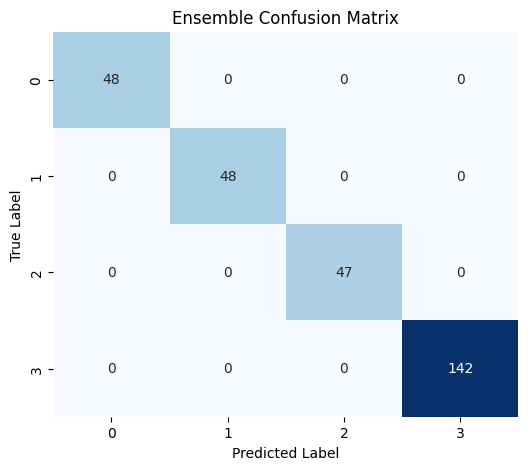

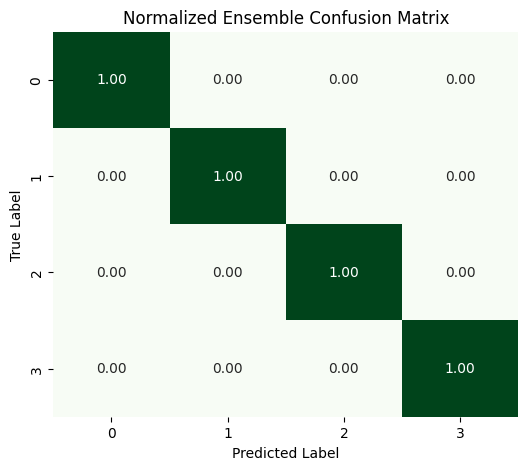

In [54]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_ensemble)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Ensemble Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Optional: Normalized Confusion Matrix
plt.figure(figsize=(6, 5))
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Greens', cbar=False)
plt.title("Normalized Ensemble Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### 2. Accuracy Plots

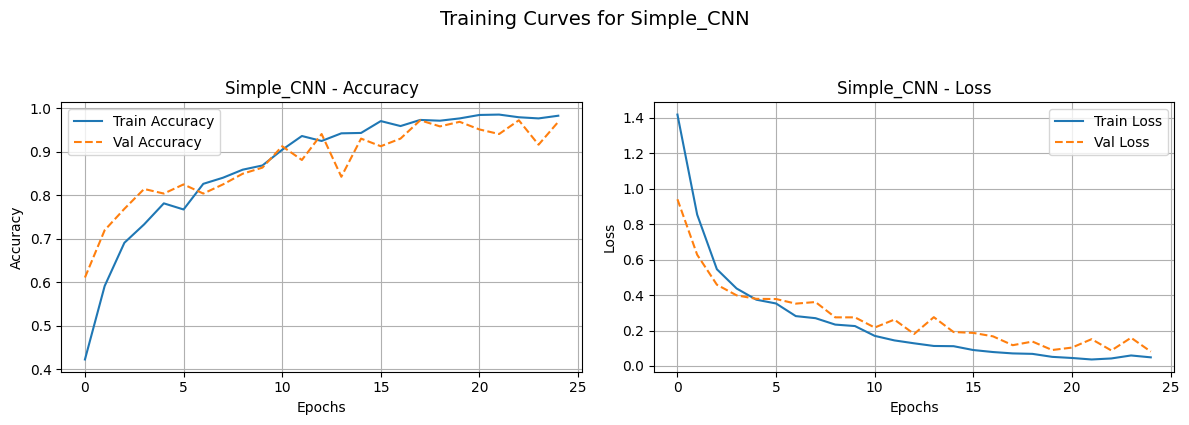

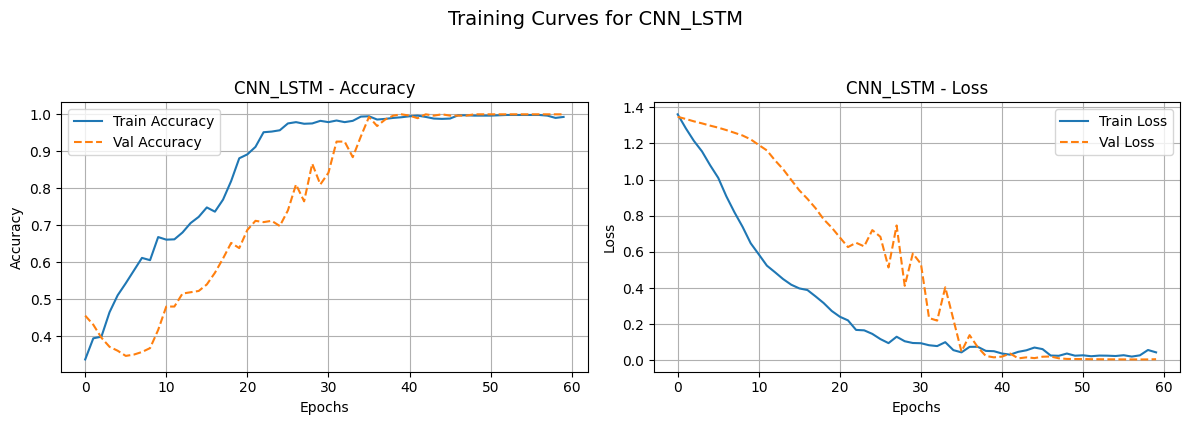

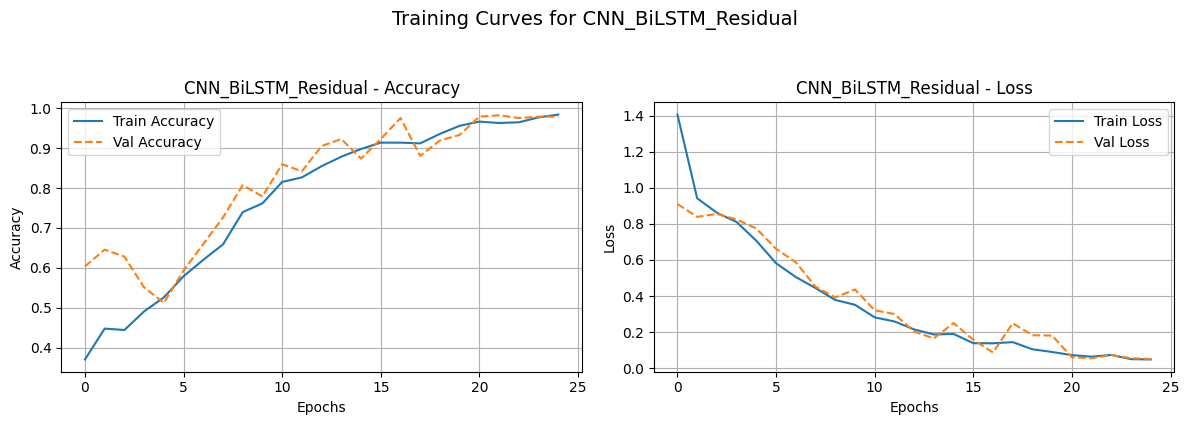

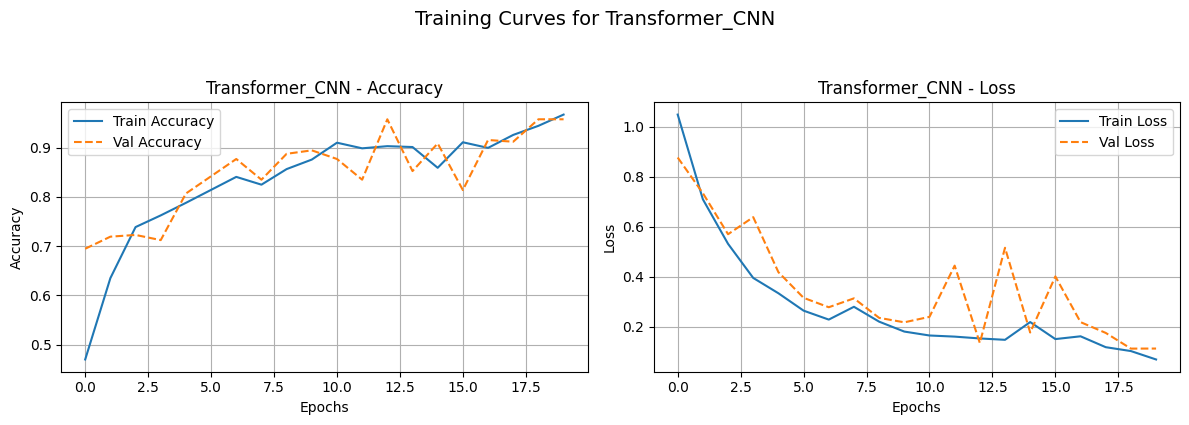

In [55]:
for name, hist in histories.items():
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # --- Accuracy ---
    axes[0].plot(hist.history['accuracy'], label='Train Accuracy')
    axes[0].plot(hist.history['val_accuracy'], '--', label='Val Accuracy')
    axes[0].set_title(f'{name} - Accuracy')
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Accuracy")
    axes[0].legend()
    axes[0].grid(True)

    # --- Loss ---
    axes[1].plot(hist.history['loss'], label='Train Loss')
    axes[1].plot(hist.history['val_loss'], '--', label='Val Loss')
    axes[1].set_title(f'{name} - Loss')
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Loss")
    axes[1].legend()
    axes[1].grid(True)

    # Adjust layout
    plt.suptitle(f"Training Curves for {name}", fontsize=14, y=1.05)
    plt.tight_layout()
    plt.show()


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 191ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 189ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 195ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step


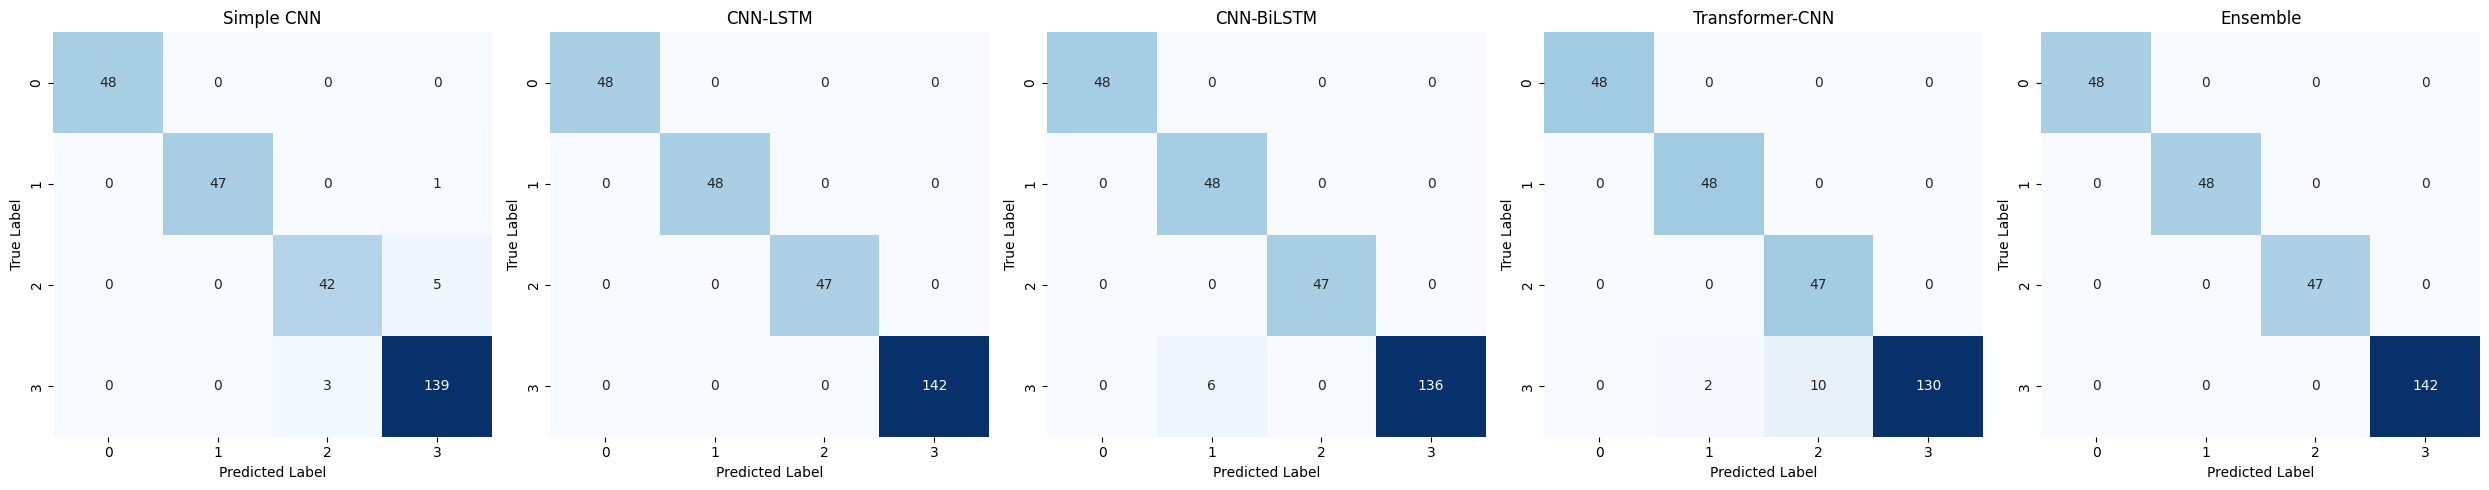

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Predict with all models ---
pred_cnn = np.argmax(m1.predict(X_test), axis=1)
pred_cnn_lstm = np.argmax(m2.predict(X_test), axis=1)
pred_cnn_bilstm = np.argmax(m3.predict(X_test), axis=1)
pred_trans_cnn = np.argmax(m4.predict(X_test), axis=1)

# Ensemble (already done)
ensemble_pred = np.mean([
    m1.predict(X_test),
    m2.predict(X_test),
    m3.predict(X_test),
    m4.predict(X_test)
], axis=0)
pred_ensemble = np.argmax(ensemble_pred, axis=1)

# --- Compute confusion matrices ---
cms = {
    "Simple CNN": confusion_matrix(y_true, pred_cnn),
    "CNN-LSTM": confusion_matrix(y_true, pred_cnn_lstm),
    "CNN-BiLSTM": confusion_matrix(y_true, pred_cnn_bilstm),
    "Transformer-CNN": confusion_matrix(y_true, pred_trans_cnn),
    "Ensemble": confusion_matrix(y_true, pred_ensemble)
}

# --- Plot ---
fig, axes = plt.subplots(1, 5, figsize=(25, 5))
for ax, (title, cm) in zip(axes, cms.items()):
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Predicted Label")
    ax.set_ylabel("True Label")

plt.tight_layout()
plt.show()


In [60]:
# Source - https://stackoverflow.com/a
# Posted by Basj, modified by community. See post 'Timeline' for change history
# Retrieved 2025-11-08, License - CC BY-SA 4.0

import psutil
process = psutil.Process()
print(process.memory_info().rss)  # in bytes


300613632
